In [143]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

set_label = ['50-25','75-37','100-50','125-67','150-75']
set_A_05 = ['1226_1700', '1226_1713', '1226_1727', '1226_1741', '1226_1756']
set_B_02 = ['0104_2223', '0104_2309', '0104_2328', '0104_2343', '0105_0013']
set_C_10 = ['0116_0117', '0116_0125', '0116_0132', '0116_0140', '0116_0149']
set_D_06 = ['0104_1949', '0104_2002', '0104_2016', '0104_2032', '0104_2056']

selected_set = set_B_02
set_name = './imagesets/B_S1_0.08.txt'
mertic = 7.5
mertic2 = 2.4
# B:8.04% -> 1.1
# D:9.15% -> 0.8

In [144]:
# df = pd.read_csv(s1s2_path)
# X = np.array([df['scan_enp'], df['bev_enp']]).T
# y = np.array(df['s1_gt'])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

def evaluate_regression(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return mse, rmse, mae, r2

In [145]:
idx, scan_entropy_list, bev_entropy_list, pf_scalar_list, pf_vector_list, s1_gt =[], [], [], [], [], []
empty_file = []
sub_cnt = 0
for time_dirc in selected_set:
    sem_pt_path = '/home/newDisk/tool/carla_dataset_tool/raw_data/record_2024_'+time_dirc+'/vehicle.tesla.model3.master/velodyne_semantic/'
    file_list = os.listdir(sem_pt_path)
    file_list = [f for f in file_list if f.endswith('.txt')]
    file_list.sort()

    for file_name in file_list:
        gt = 0
        with open(sem_pt_path+file_name, 'r') as f:
            lines = f.readlines()
            last_line = lines[-1]
            if len(lines) ==1:
                empty_file.append(str(sub_cnt)+file_name[-9:-4])
            else:
                scores = last_line.split(' ')
                s1_gt.append(scores[0])
                scan_entropy_list.append(np.float64(scores[1]))
                bev_entropy_list.append(np.float64(scores[2]))
                pf_scalar_list.append(np.float64(scores[3]))
                pf_vector_list.append(np.float64(scores[4].replace('\n','')))
                idx.append(str(sub_cnt)+file_name[-9:-4])

    sub_cnt += 1


In [146]:
len(scan_entropy_list)

4658

In [147]:
df = pd.DataFrame({'idx':idx, 'scan_enp':scan_entropy_list, 'bev_enp':bev_entropy_list, 'pf_scalar':pf_scalar_list, 'pf_vector':pf_vector_list, 's1_gt':s1_gt})
X = np.array([df['scan_enp'], df['bev_enp'],df['idx']]).T
y = np.array(df['s1_gt'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

train_idx = X_train[:,-1]
test_idx = X_test[:,-1]
X_train = X_train[:,:-1]
X_test = X_test[:,:-1]

# sns.scatterplot(x=bev_entropy_list, y=s1_gt)

In [148]:
print(len(X_train), len(X_test), mertic)

gbr = GradientBoostingRegressor(loss='huber',learning_rate=0.2,n_estimators=100, min_samples_leaf=10, max_depth=10, max_features=15, random_state=42)
gbr.fit(X_train,y_train)


y_pred_train = gbr.predict(X_train)
gbr_mse, gbr_rmse, gbr_mae, gbr_r2 = evaluate_regression(y_train, y_pred_train)
print('[GBR x and y] test on train dataset')
print('mse: ', gbr_mse)
print('rmse: ', gbr_rmse)
print('mae: ', gbr_mae)
print('r2: ', gbr_r2)

y_pred_test = gbr.predict(X_test)
gbr_mse, gbr_rmse, gbr_mae, gbr_r2 = evaluate_regression(y_test, y_pred_test)
print('[GBR x and y] test on test dataset')
print('mse: ', gbr_mse)
print('rmse: ', gbr_rmse)
print('mae: ', gbr_mae)
print('r2: ', gbr_r2)

# calculate the accuary with metric
y_pred2 = y_pred_test.copy()
y_test2 = y_test.copy()
y_pred2[y_pred2 <= mertic] = 0
y_pred2[y_pred2 > mertic] = 1
y_test2[np.float64(y_test2) <= mertic] = 0
y_test2[np.float64(y_test2) > mertic] = 1
accuracy = np.sum(y_pred2 == y_test2) / len(y_test2)

print("ratio:",len(y_pred2[y_pred2 == 1]) / len(y_pred2))


print('accuracy: ', accuracy)
        
# get the idx, where y_pred2 == 1 at the same place
idx_lower = test_idx[y_pred2 == 0]
idx_higher = test_idx[y_pred2 == 1]

idx_lower = np.array(idx_lower, dtype=np.int32)
idx_higher = np.array(idx_higher, dtype=np.int32)

print("lower count:", len(idx_lower), "; all count:",  len(y_test))


931 3727 7.5
[GBR x and y] test on train dataset
mse:  2.1189078522767715
rmse:  1.4556468844732817
mae:  0.7903050667500368
r2:  0.7627184542263621
[GBR x and y] test on test dataset
mse:  5.312919396041059
rmse:  2.304977092302884
mae:  1.4923082701282764
r2:  0.3897560535700091
ratio: 0.11939898041320096
accuracy:  0.9012610678830159
lower count: 3282 ; all count: 3727


In [149]:
idx_lower

array([113259, 428996, 236581, ..., 113520, 115335, 235987], dtype=int32)

In [150]:
# S2
PF_ALPHA = 1.5
PF_K = 1.0
PF_D = 1E5
PF_H = 0.5
PF_RANGE = 60

def function_S2(dist, mesh, bbox_size):
    l = dist / PF_RANGE
    score = (dist**2 * mesh / (bbox_size*np.sqrt(bbox_size))) / (PF_D * (l * np.log(l)+ PF_H))
    return score


car_df = pd.DataFrame(columns=['dist', 'mesh', 'bbox_size', 'frame_id'])
truck_df = pd.DataFrame(columns=['dist', 'mesh', 'bbox_size', 'frame_id'])
van_df = pd.DataFrame(columns=['dist', 'mesh', 'bbox_size', 'frame_id'])

for i in range(len(selected_set)):
    time_dirc = selected_set[i]
    sem_pt_path = '/home/newDisk/tool/carla_dataset_tool/raw_data/record_2024_'+time_dirc+'/vehicle.tesla.model3.master/velodyne_semantic/'
    file_list = os.listdir(sem_pt_path)
    file_list = [f for f in file_list if f.endswith('.txt')]
    file_list.sort()

    for file in file_list:
        with open(sem_pt_path+file) as f:
            lines = f.readlines()[:-1]

            for line in lines:
                line = line.strip().split()
                if line[7] == 'Car':
                    cy, cz, cx = np.float64(line[0]), np.float64(line[1]), np.float64(line[2])
                    sy, sx ,sz = np.float64(line[3]), np.float64(line[4]), np.float64(line[5])
                    dist = np.sqrt(cx**2 + cy**2 + (cz-0.5*sz)**2)
                    if dist < PF_RANGE:
                        mesh = min(2000, np.float64(line[8]))
                        bbox_size = np.sqrt(sx**2 + sy**2 + sz**2)
                        new_row = pd.Series({'dist': dist, 'mesh': mesh, 'bbox_size': bbox_size, 'frame_id': int(str(i)+file[-9:-4])})
                        car_df = pd.concat([car_df, new_row.to_frame().T], ignore_index=True)
                elif line[7] == 'Truck':
                    cy, cz, cx = np.float64(line[0]), np.float64(line[1]), np.float64(line[2])
                    sy, sx ,sz = np.float64(line[3]), np.float64(line[4]), np.float64(line[5])
                    dist = np.sqrt(cx**2 + cy**2 + (cz-0.5*sz)**2)
                    if dist < PF_RANGE:
                        mesh = min(2000, np.float64(line[8]))
                        bbox_size = np.sqrt(sx**2 + sy**2 + sz**2)
                        new_row = pd.Series({'dist': dist, 'mesh': mesh, 'bbox_size': bbox_size, 'frame_id': int(str(i)+file[-9:-4])})
                        truck_df = pd.concat([truck_df, new_row.to_frame().T], ignore_index=True)
                elif line[7] == 'Van':
                    cy, cz, cx = np.float64(line[0]), np.float64(line[1]), np.float64(line[2])
                    sy, sx ,sz = np.float64(line[3]), np.float64(line[4]), np.float64(line[5])
                    dist = np.sqrt(cx**2 + cy**2 + (cz-0.5*sz)**2)
                    if dist< PF_RANGE:
                        mesh = min(2000, np.float64(line[8]))
                        bbox_size = np.sqrt(sx**2 + sy**2 + sz**2)
                        new_row = pd.Series({'dist': dist, 'mesh': mesh, 'bbox_size': bbox_size, 'frame_id': int(str(i)+file[-9:-4])})
                        van_df = pd.concat([van_df, new_row.to_frame().T], ignore_index=True)

In [151]:
car_df.shape, truck_df.shape, van_df.shape

((15603, 4), (3580, 4), (332, 4))

In [152]:
# only keep the frame id that is in idx_lower 
car_df2 = car_df[car_df['frame_id'].isin(idx_lower)]
truck_df2 = truck_df[truck_df['frame_id'].isin(idx_lower)]
van_df2 = van_df[van_df['frame_id'].isin(idx_lower)]

car_df2.shape, truck_df2.shape, van_df2.shape

((9954, 4), (2063, 4), (208, 4))

In [153]:
car_score = function_S2(car_df2['dist'], car_df2['mesh'], car_df2['bbox_size'])
truck_score = function_S2(truck_df2['dist'], truck_df2['mesh'], truck_df2['bbox_size'])
van_score = function_S2(van_df2['dist'], van_df2['mesh'], van_df2['bbox_size'])

# use .loc save the score to a new column, type is np.float64
car_df2.loc[:,'score'] = car_score
truck_df2.loc[:,'score'] = truck_score
van_df2.loc[:,'score'] = van_score

# frame_id to type int32
car_df2['frame_id'] = car_df2['frame_id'].astype(np.int32)
truck_df2['frame_id'] = truck_df2['frame_id'].astype(np.int32)
van_df2['frame_id'] = van_df2['frame_id'].astype(np.int32)

car_df2.head()

/tmp/ipykernel_59516/2141701409.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  car_df2.loc[:,'score'] = car_score
/tmp/ipykernel_59516/2141701409.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  truck_df2.loc[:,'score'] = truck_score
/tmp/ipykernel_59516/2141701409.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,dist,mesh,bbox_size,frame_id,score
0,54.854212,50.0,5.817201,19898,0.256518
1,51.760444,148.0,5.817201,19901,0.758546
3,45.930213,218.0,5.817201,19907,1.109460
4,42.986280,182.0,5.817201,19910,0.918043
5,40.465075,296.0,5.817201,19913,1.474107


In [154]:
car_df3 = car_df2.groupby('frame_id').sum()
truck_df3 = truck_df2.groupby('frame_id').sum()
van_df3 = van_df2.groupby('frame_id').sum()

print(car_df3.head())
print(idx_lower)

# sum three types vehicle score by frame id, save frame id and score at a new dataframe
vehicle_df = pd.DataFrame(columns=['frame_id', 'score'])
for frame_id in car_df3.index:
    # get score use index
    car_score = car_df3.loc[frame_id]['score']
    if frame_id in truck_df3.index:
        truck_score = truck_df3.loc[frame_id]['score']
    else:
        truck_score = 0

    if frame_id in van_df3.index:
        van_score = van_df3.loc[frame_id]['score']
    else:
        van_score = 0

    score = car_score + truck_score + van_score
    
    new_row = pd.Series({'frame_id': frame_id, 'score': score})
    vehicle_df = pd.concat([vehicle_df, new_row.to_frame().T], ignore_index=True)

               dist   mesh  bbox_size     score
frame_id                                       
19898     54.854212   50.0   5.817201  0.256518
19901     51.760444  148.0   5.817201  0.758546
19907     45.930213  218.0   5.817201  1.109460
19910     42.986280  182.0   5.817201  0.918043
19913     40.465075  296.0   5.817201  1.474107
[113259 428996 236581 ... 113520 115335 235987]


/tmp/ipykernel_59516/2683256851.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vehicle_df['score'])


<Axes: xlabel='score', ylabel='Density'>

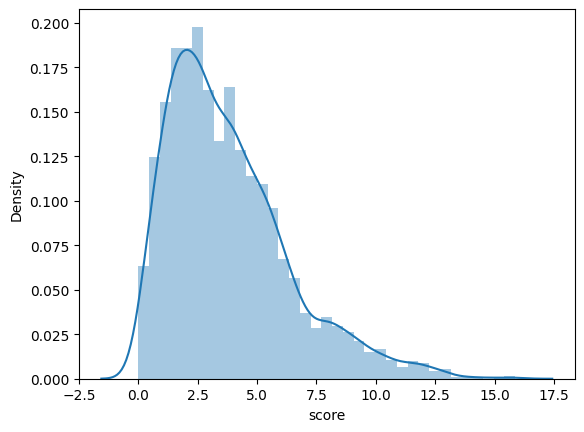

In [167]:
# visualize the distribution of score
sns.distplot(vehicle_df['score'])

In [171]:
print(vehicle_df['score'].min(), vehicle_df['score'].max())

ratio = len(vehicle_df[vehicle_df['score'] < mertic2]) / len(vehicle_df)
print("S2 spilt",ratio)

idx_test = vehicle_df[vehicle_df['score'] < mertic2].values

idx_test = np.array(idx_test, dtype=np.int32)
print("S1S2 spilt", len(idx_test) / len(y_test))

print("all frame count", len(train_idx)+ len(idx_test))

0.0 15.868007309198862
S2 spilt 0.35342465753424657
S1S2 spilt 0.27689830963241213
all frame count 1963


In [156]:
# frame_id = train_idx + test_idx, write to imageset
train_list = train_idx.tolist() + idx_test.tolist()
train_list.sort()

test_list = []
val_list = []
test_spilt = 12
val_spilt = 15

# idx should not has element in empty_file
for id in empty_file:
    if id in train_list:
        train_list.remove(id)

train_path = './imagesets/D/train.txt'
test_path = './imagesets/D/test.txt'
val_path = './imagesets/D/val.txt'


for i in range(len(train_list)):
    if i % test_spilt == 0:
        test_list.append(train_list[i])
        train_list[i] = 'none'
    if i % val_spilt == 0:
        val_list.append(train_list[i])
        train_list[i] = 'none'

train_list = [x for x in train_list if x != 'none']
val_list = [x for x in val_list if x != 'none']

with open(train_path, 'w') as f:
    for item in train_list:
        f.write("%s\n" % item)

with open(test_path, 'w') as f:
    for item in test_list:
        f.write("%s\n" % item)

with open(val_path, 'w') as f:
    for item in val_list:
        f.write("%s\n" % item)